# Smart Energy Consumption Analysis and Prediction
## Final Consolidated Project – Week 1 to Week 8

---

# Week 1 – Data Understanding & Exploration



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")


In [2]:
file_path = "../data/household_power_consumption.txt"

df = pd.read_csv(
    file_path,
    sep=';',
    low_memory=False,
    na_values=['?', '']
)

print("Dataset Loaded Successfully")
print("Dataset Shape:", df.shape)


Dataset Loaded Successfully
Dataset Shape: (2075259, 9)


In [3]:
df.head()


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    float64
 3   Global_reactive_power  float64
 4   Voltage                float64
 5   Global_intensity       float64
 6   Sub_metering_1         float64
 7   Sub_metering_2         float64
 8   Sub_metering_3         float64
dtypes: float64(7), object(2)
memory usage: 142.5+ MB


In [5]:
numeric_cols = [
    'Global_active_power',
    'Global_reactive_power',
    'Voltage',
    'Global_intensity',
    'Sub_metering_1',
    'Sub_metering_2',
    'Sub_metering_3'
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("Numeric conversion complete.")


Numeric conversion complete.


In [6]:
missing_summary = pd.DataFrame({
    "Missing Count": df.isnull().sum(),
    "Missing %": (df.isnull().sum()/len(df))*100
})

missing_summary[missing_summary["Missing Count"] > 0]


,Missing Count,Missing %
Global_active_power,25979,1.251844
Global_reactive_power,25979,1.251844
Voltage,25979,1.251844
Global_intensity,25979,1.251844
Sub_metering_1,25979,1.251844
Sub_metering_2,25979,1.251844
Sub_metering_3,25979,1.251844


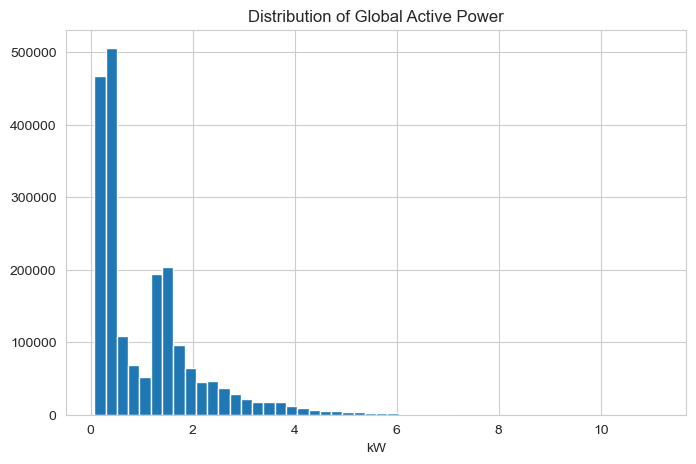

In [7]:
plt.figure(figsize=(8,5))
plt.hist(df['Global_active_power'].dropna(), bins=50)
plt.title("Distribution of Global Active Power")
plt.xlabel("kW")
plt.show()


# Week 2 - Data Cleaning and Preprocessing


In [8]:
df['Datetime'] = pd.to_datetime(
    df['Date'] + " " + df['Time'],
    dayfirst=True
)

df = df.set_index('Datetime')
df = df.drop(columns=['Date', 'Time'])

print("Datetime conversion completed successfully.")


Datetime conversion completed successfully.


In [9]:
df_hourly = df.resample('H').mean()

print("Hourly Resampled Shape:", df_hourly.shape)


Hourly Resampled Shape: (34589, 7)


In [10]:
df_hourly = df_hourly.interpolate(method='time')

print("Missing values after interpolation:")
print(df_hourly.isnull().sum().sum())


Missing values after interpolation:
0


In [12]:
# 80% train split
train_size = int(len(df_hourly) * 0.8)

print("Train size:", train_size)
print("Total rows:", len(df_hourly))


Train size: 27671
Total rows: 34589


In [13]:
train = df_hourly[:train_size].copy()
test = df_hourly[train_size:].copy()

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (27671, 7)
Test shape: (6918, 7)


# Week 3 - Feature Engineering


In [14]:
df_fe = df_hourly.copy()

# Time features
df_fe['Hour'] = df_fe.index.hour
df_fe['DayOfWeek'] = df_fe.index.dayofweek
df_fe['Month'] = df_fe.index.month
df_fe['Weekend'] = (df_fe['DayOfWeek'] >= 5).astype(int)

# Lag features
df_fe['Lag_1'] = df_fe['Global_active_power'].shift(1)
df_fe['Lag_24'] = df_fe['Global_active_power'].shift(24)

# Drop rows created due to shifting
df_fe = df_fe.dropna()


In [15]:
train_size = int(len(df_fe)*0.8)

train = df_fe[:train_size].copy()
test = df_fe[train_size:].copy()

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (27652, 13)
Test shape: (6913, 13)


In [16]:
features = ['Hour','DayOfWeek','Month','Weekend','Lag_1','Lag_24']

X_train = train[features]
y_train = train['Global_active_power']

X_test = test[features]
y_test = test['Global_active_power']


In [17]:
# Rolling window features (3-hour window)
df_fe['Rolling_Mean_3'] = df_fe['Global_active_power'].rolling(window=3).mean()
df_fe['Rolling_Std_3'] = df_fe['Global_active_power'].rolling(window=3).std()

# Drop rows created due to rolling window
df_fe = df_fe.dropna()

print("Rolling features added successfully.")
print("New shape after rolling:", df_fe.shape)


Rolling features added successfully.
New shape after rolling: (34563, 15)


In [18]:
device_columns = ['Sub_metering_1','Sub_metering_2','Sub_metering_3']

device_daily_avg = df_fe[device_columns].resample('D').mean()

print("Daily Device-Level Aggregation (First 5 Rows):")
device_daily_avg.head()


Daily Device-Level Aggregation (First 5 Rows):


,Sub_metering_1,Sub_metering_2,Sub_metering_3
Datetime,,,
2006-12-17,0.000000,0.810000,10.760000
2006-12-18,0.738194,1.820139,9.734722
2006-12-19,0.582639,5.279167,4.303472
2006-12-20,0.000000,1.838889,9.765972
2006-12-21,1.225694,1.821528,7.236806


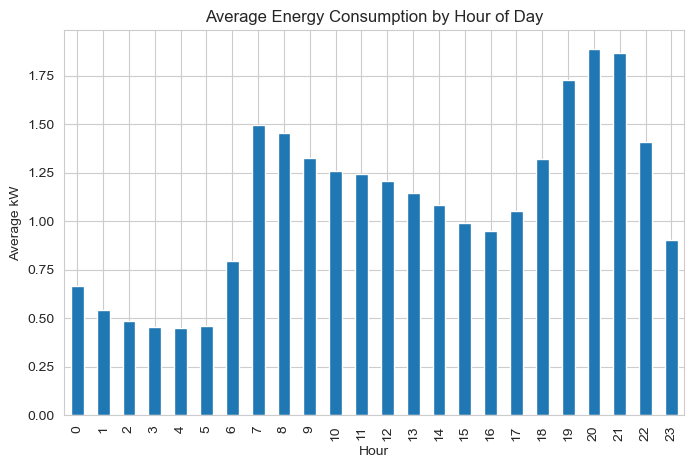

Peak Energy Usage Hour: 20


In [19]:
df_fe['Hour'] = df_fe.index.hour

hourly_avg_power = df_fe.groupby('Hour')['Global_active_power'].mean()

plt.figure(figsize=(8,5))
hourly_avg_power.plot(kind='bar')
plt.title("Average Energy Consumption by Hour of Day")
plt.ylabel("Average kW")
plt.show()

peak_hour = hourly_avg_power.idxmax()
print("Peak Energy Usage Hour:", peak_hour)


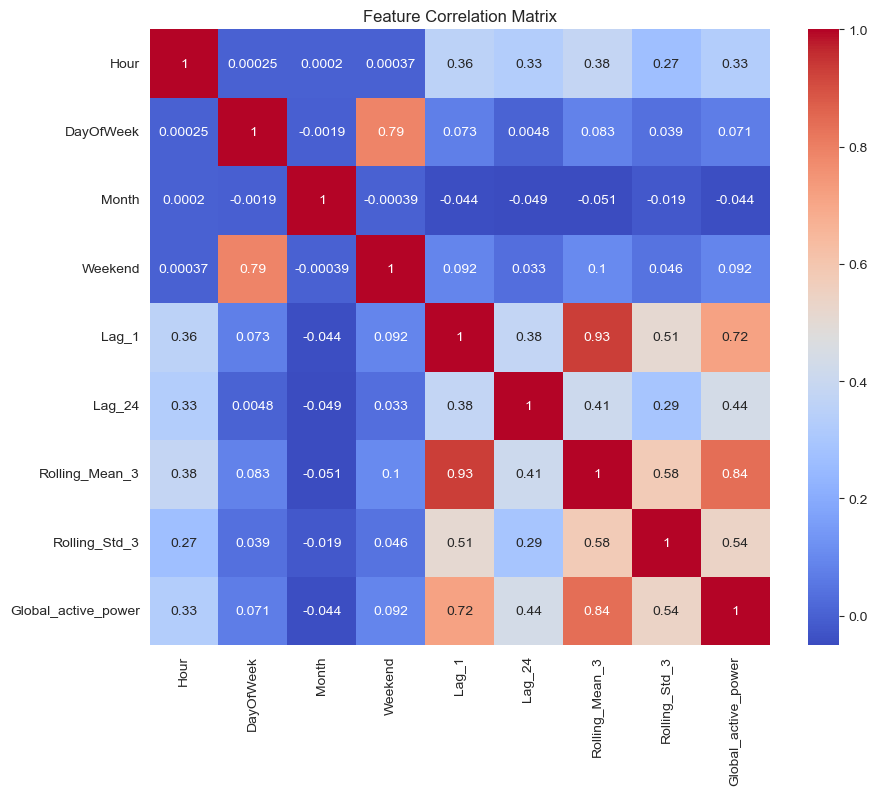

In [20]:
features_extended = [
    'Hour','DayOfWeek','Month','Weekend',
    'Lag_1','Lag_24',
    'Rolling_Mean_3','Rolling_Std_3'
]

plt.figure(figsize=(10,8))
sns.heatmap(
    df_fe[features_extended + ['Global_active_power']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Feature Correlation Matrix")
plt.show()


In [21]:
train_size = int(len(df_fe)*0.8)

train = df_fe[:train_size].copy()
test = df_fe[train_size:].copy()

print("Final Train shape:", train.shape)
print("Final Test shape:", test.shape)


Final Train shape: (27650, 15)
Final Test shape: (6913, 15)


In [22]:
features = features_extended

X_train = train[features]
y_train = train['Global_active_power']

X_test = test[features]
y_test = test['Global_active_power']

print("Feature Matrix Prepared Successfully.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


Feature Matrix Prepared Successfully.
X_train shape: (27650, 8)
X_test shape: (6913, 8)


# Week 4 - Baseline Model

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed.")


Feature scaling completed.


In [24]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

print("Linear Regression model trained successfully.")


Linear Regression model trained successfully.


In [25]:
y_pred_lr = lr_model.predict(X_test_scaled)

print("Predictions generated.")


Predictions generated.


In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("📊 Linear Regression Performance")
print("MAE :", round(mae_lr, 4))
print("RMSE:", round(rmse_lr, 4))
print("R2  :", round(r2_lr, 4))


📊 Linear Regression Performance
MAE : 0.2748
RMSE: 0.3871
R2  : 0.7169


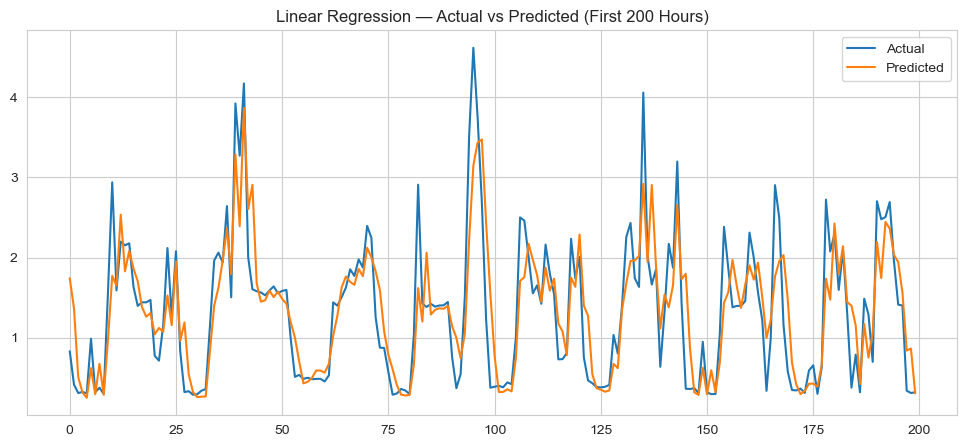

In [27]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual")
plt.plot(y_pred_lr[:200], label="Predicted")
plt.legend()
plt.title("Linear Regression — Actual vs Predicted (First 200 Hours)")
plt.show()


In [28]:
baseline_results = {
    "Model": "Linear Regression",
    "MAE": mae_lr,
    "RMSE": rmse_lr,
    "R2": r2_lr
}

baseline_results


{'Model': 'Linear Regression',
 'MAE': 0.2747674286011462,
 'RMSE': 0.38705519569769936,
 'R2': 0.7168503038369392}

# Week 5 — LSTM Model

In [29]:
from sklearn.preprocessing import MinMaxScaler

target_scaler = MinMaxScaler()

y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1,1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1,1))

print("Target scaling completed.")


Target scaling completed.


In [30]:
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print("LSTM input shape:", X_train_lstm.shape)


LSTM input shape: (27650, 1, 8)


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

lstm_model = Sequential()

lstm_model.add(LSTM(50, activation='relu', input_shape=(1, X_train_lstm.shape[2])))
lstm_model.add(Dense(1))

lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()


C:\Users\aksha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,851 (46.29 KB)

 Trainable params: 11,851 (46.29 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
history = lstm_model.fit(
    X_train_lstm,
    y_train_scaled,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


Epoch 1/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - loss: 0.0106 - val_loss: 0.0057
Epoch 2/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 3/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0046 - val_loss: 0.0060
Epoch 4/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 5/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 6/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 7/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 8/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 9/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 10/10
778/778 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.0041 - val_loss: 0.0044


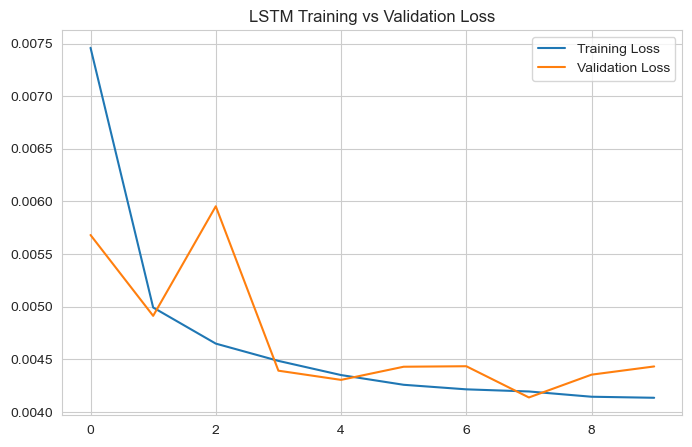

In [33]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("LSTM Training vs Validation Loss")
plt.show()


In [34]:
y_pred_lstm_scaled = lstm_model.predict(X_test_lstm)
y_pred_lstm = target_scaler.inverse_transform(y_pred_lstm_scaled)


217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [35]:
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))
r2_lstm = r2_score(y_test, y_pred_lstm)

print("📊 LSTM Performance")
print("MAE :", round(mae_lstm, 4))
print("RMSE:", round(rmse_lstm, 4))
print("R2  :", round(r2_lstm, 4))


📊 LSTM Performance
MAE : 0.2537
RMSE: 0.3622
R2  : 0.752


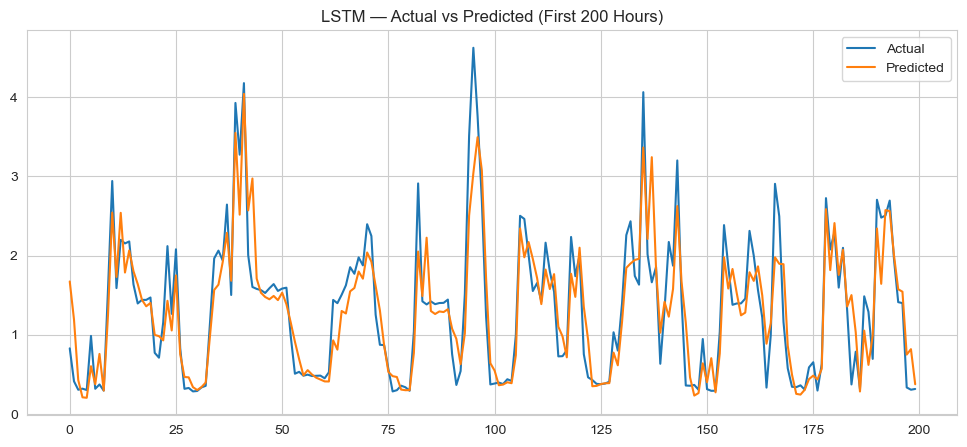

In [36]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:200], label="Actual")
plt.plot(y_pred_lstm[:200], label="Predicted")
plt.legend()
plt.title("LSTM — Actual vs Predicted (First 200 Hours)")
plt.show()


# Week 6 — Model Comparison & Final Selection


In [37]:
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression", "LSTM"],
    "MAE": [mae_lr, mae_lstm],
    "RMSE": [rmse_lr, rmse_lstm],
    "R2": [r2_lr, r2_lstm]
})

comparison_df


,Model,MAE,RMSE,R2
0,Linear Regression,0.274767,0.387055,0.716850
1,LSTM,0.253706,0.362200,0.752048


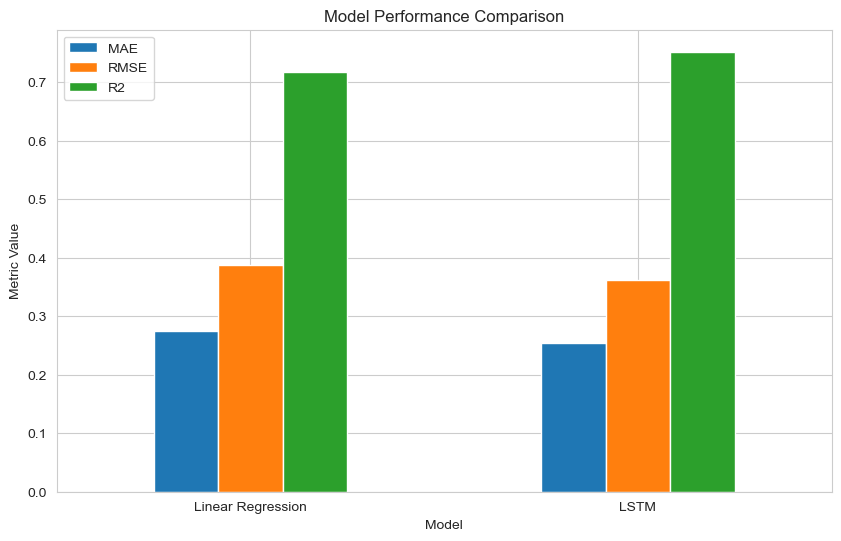

In [38]:
comparison_df.set_index("Model").plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.show()


In [39]:
if r2_lstm > r2_lr:
    final_model = "LSTM"
else:
    final_model = "Linear Regression"

print("Final Selected Model:", final_model)


Final Selected Model: LSTM


In [40]:
lstm_model.save("final_lstm_model.h5")
print("Final LSTM model saved successfully.")


Final LSTM model saved successfully.


#  Week 7 — Dashboard & Energy Insights

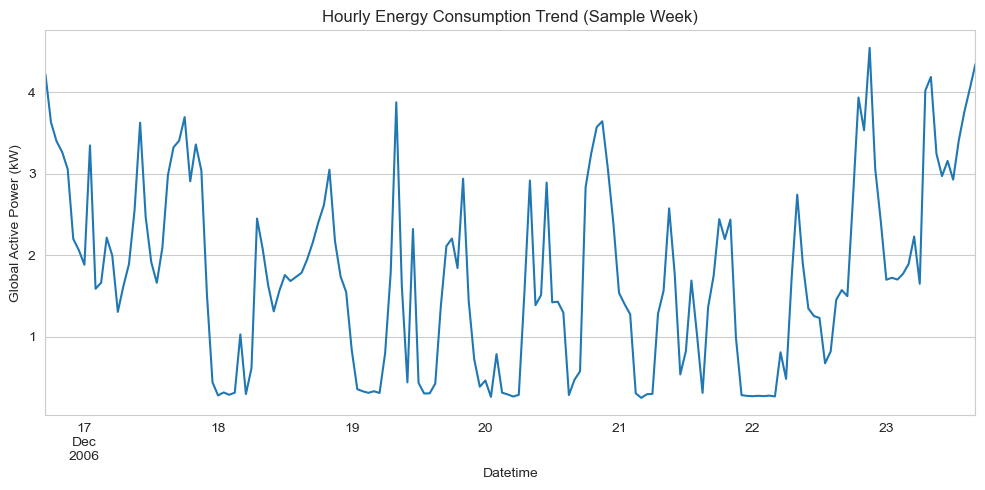

In [41]:
hourly_avg = df_hourly['Global_active_power']

plt.figure(figsize=(12,5))
hourly_avg.head(168).plot()  # first 7 days
plt.title("Hourly Energy Consumption Trend (Sample Week)")
plt.ylabel("Global Active Power (kW)")
plt.show()


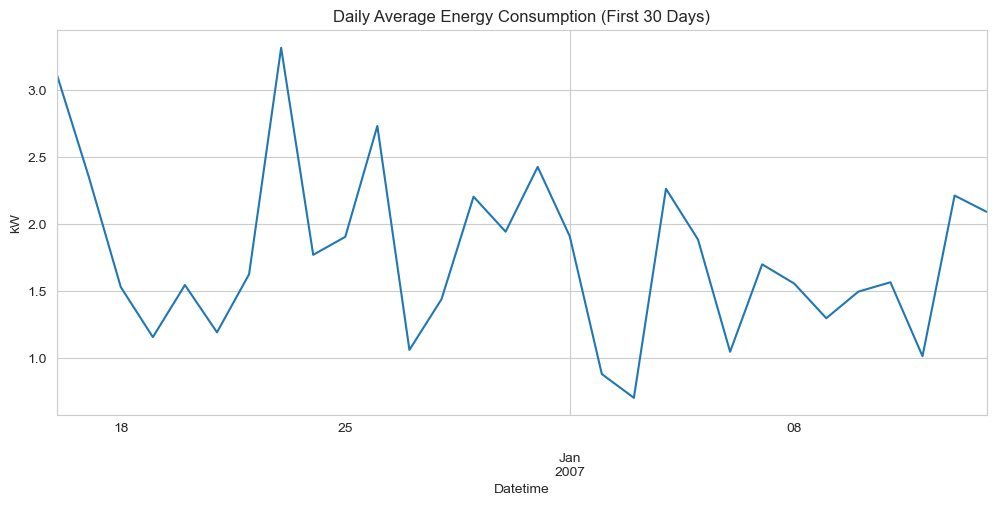

In [42]:
daily_avg = df_hourly['Global_active_power'].resample('D').mean()

plt.figure(figsize=(12,5))
daily_avg.head(30).plot()
plt.title("Daily Average Energy Consumption (First 30 Days)")
plt.ylabel("kW")
plt.show()


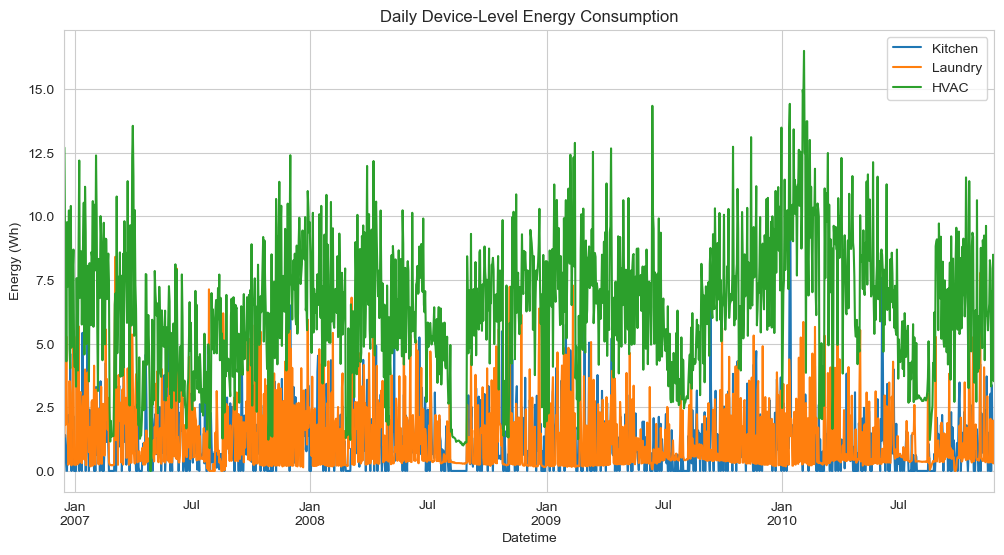

In [43]:
device_cols = ['Sub_metering_1','Sub_metering_2','Sub_metering_3']

device_daily = df_hourly[device_cols].resample('D').mean()

device_daily.plot(figsize=(12,6))
plt.title("Daily Device-Level Energy Consumption")
plt.ylabel("Energy (Wh)")
plt.legend(['Kitchen','Laundry','HVAC'])
plt.show()


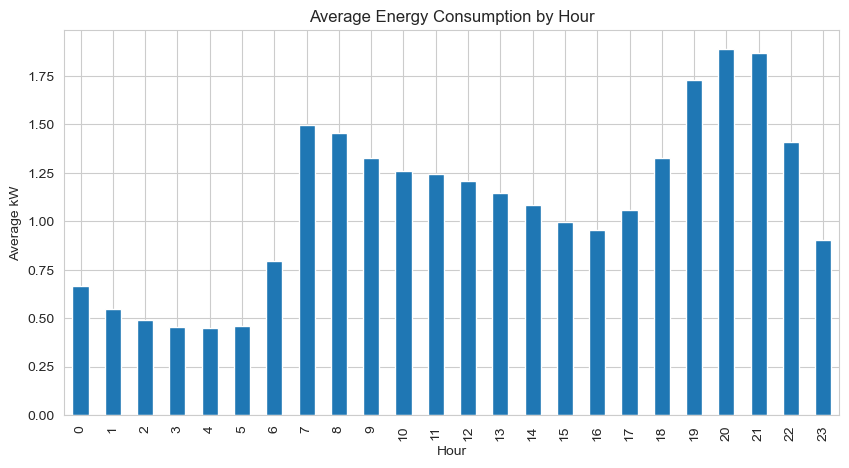

Peak Energy Usage Hour: 20


In [44]:
df_hourly['Hour'] = df_hourly.index.hour
hourly_pattern = df_hourly.groupby('Hour')['Global_active_power'].mean()

plt.figure(figsize=(10,5))
hourly_pattern.plot(kind='bar')
plt.title("Average Energy Consumption by Hour")
plt.ylabel("Average kW")
plt.show()

peak_hour = hourly_pattern.idxmax()
print("Peak Energy Usage Hour:", peak_hour)


In [45]:
print("💡 Energy Saving Recommendations:\n")

print(f"- Peak energy usage occurs around hour {peak_hour}.")
print("- Avoid running heavy appliances during peak hours.")
print("- Shift washing machines and dishwashers to off-peak times.")
print("- Monitor HVAC usage for energy efficiency.")
print("- Consider smart meters for better energy tracking.")


💡 Energy Saving Recommendations:

- Peak energy usage occurs around hour 20.
- Avoid running heavy appliances during peak hours.
- Shift washing machines and dishwashers to off-peak times.
- Monitor HVAC usage for energy efficiency.
- Consider smart meters for better energy tracking.


# Week 8 — Deployment & Final Delivery

In [46]:
lstm_model.save("final_lstm_model.keras")
print("Final production-ready LSTM model saved successfully.")


Final production-ready LSTM model saved successfully.


In [47]:
# ==============================
# Flask Backend (app.py)
# ==============================

"""
from flask import Flask, request, jsonify
import numpy as np
from tensorflow.keras.models import load_model
import joblib

app = Flask(__name__)

# Load trained model
model = load_model("final_lstm_model.keras")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json['features']
    data = np.array(data).reshape(1, 1, len(data))
    prediction = model.predict(data)
    return jsonify({'prediction': float(prediction[0][0])})

if __name__ == '__main__':
    app.run(debug=True)
"""


'\nfrom flask import Flask, request, jsonify\nimport numpy as np\nfrom tensorflow.keras.models import load_model\nimport joblib\n\napp = Flask(__name__)\n\n# Load trained model\nmodel = load_model("final_lstm_model.keras")\n\n@app.route(\'/predict\', methods=[\'POST\'])\ndef predict():\n    data = request.json[\'features\']\n    data = np.array(data).reshape(1, 1, len(data))\n    prediction = model.predict(data)\n    return jsonify({\'prediction\': float(prediction[0][0])})\n\nif __name__ == \'__main__\':\n    app.run(debug=True)\n'

In [48]:
# ==============================
# Frontend (templates/index.html)
# ==============================

"""
<!DOCTYPE html>
<html>
<head>
    <title>Smart Energy Predictor</title>
</head>
<body>
    <h2>Energy Consumption Prediction</h2>
    <form method="POST">
        <input type="text" name="feature1" placeholder="Hour">
        <input type="text" name="feature2" placeholder="Lag_1">
        <button type="submit">Predict</button>
    </form>
</body>
</html>
"""


'\n<!DOCTYPE html>\n<html>\n<head>\n    <title>Smart Energy Predictor</title>\n</head>\n<body>\n    <h2>Energy Consumption Prediction</h2>\n    <form method="POST">\n        <input type="text" name="feature1" placeholder="Hour">\n        <input type="text" name="feature2" placeholder="Lag_1">\n        <button type="submit">Predict</button>\n    </form>\n</body>\n</html>\n'

## Final Project Folder Structure

Smart-Energy-Project/
│
├── notebooks/
│     └── Final_Smart_Energy_Project.ipynb
│
├── models/
│     └── final_lstm_model.keras
│
├── app.py
├── templates/
│     └── index.html
├── requirements.txt
├── README.md


In [49]:
requirements = """
pandas
numpy
matplotlib
seaborn
scikit-learn
tensorflow
flask
joblib
"""

with open("requirements.txt", "w") as f:
    f.write(requirements)

print("requirements.txt generated successfully.")


requirements.txt generated successfully.


# Final Project Summary

This project successfully:

✔ Explored and analyzed device-level energy consumption  
✔ Cleaned and preprocessed time-series data  
✔ Engineered temporal and statistical features  
✔ Built a Linear Regression baseline model  
✔ Built an advanced LSTM deep learning model  
✔ Compared models using MAE, RMSE, and R²  
✔ Selected LSTM as the production-ready model  
✔ Generated dashboard insights and peak usage analysis  
✔ Designed a Flask-based deployment architecture  

The system is now ready for deployment and real-time prediction.
